In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import random
import os

import dataloaders
import utils
from importlib import reload
import config
reload(config)
reload(utils)
reload(dataloaders)

<module 'dataloaders' from 'c:\\Users\\aless\\OneDrive\\Desktop\\Projects\\melanoma-detection\\dataloaders.py'>

In [2]:
# Configurations
BATCH_SIZE = 32
INPUT_SIZE = 3
NUM_CLASSES = 7
HIDDEN_SIZE = [32, 64, 128, 256]
N_EPOCHS = 5
LR = 1e-3
LR_DECAY = 0.85
REG = 0.01

In [3]:
# Weight initilization
def update_lr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [4]:
RANDOM_SEED = 42 

def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

set_seed(RANDOM_SEED)

Random seed set as 42


In [5]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device: %s'%device)

Using device: cpu


In [6]:
# Load the dataset
train_loader, val_loader, test_loader = dataloaders.create_dataloaders()

5367
0 Index([6582, 7194, 9446, 4883, 8471, 9354, 8298, 7880, 4288, 3931,
       ...
       5311, 6949, 8322, 5578, 4426, 6265, 5734, 5191, 5390, 7270],
      dtype='int64', length=5367)
1 Index([533, 132, 964, 168, 210, 718, 449, 810, 682,  46,
       ...
       969, 714, 418, 686, 137, 194, 118, 122, 843,  27],
      dtype='int64', length=5367)
2 Index([9704, 9749, 9752, 9866, 9941, 9786, 9708, 9758, 9904, 9691,
       ...
       9894, 9884, 9879, 9928, 9859, 9851, 9826, 9746, 9839, 9951],
      dtype='int64', length=5367)
3 Index([1095, 1126, 1115, 1139, 1101, 1176, 1168, 1193, 1204, 1166,
       ...
       1185, 1201, 1108, 1124, 1126, 1139, 1203, 1184, 1135, 1173],
      dtype='int64', length=5367)
4 Index([1561, 1670, 2002, 2045, 1919, 1298, 1287, 2013, 1477, 1790,
       ...
       1477, 1323, 1738, 2216, 1903, 1852, 1410, 1665, 1908, 1670],
      dtype='int64', length=5367)
5 Index([2758, 2889, 2664, 2465, 2707, 2867, 2769, 2602, 2820, 2564,
       ...
       2796, 2958, 2958, 

Loading train images: 37569it [05:50, 107.33it/s]


tensor([[[0.4819]],

        [[0.4913]],

        [[0.4999]]])
tensor([[[0.3046]],

        [[0.3013]],

        [[0.2979]]])
Len stack: 37569
Loading complete, some files (0) were not found: []


Loading test images: 2003it [00:14, 141.74it/s]


tensor([[[0.6179]],

        [[0.6205]],

        [[0.6228]]])
tensor([[[0.1808]],

        [[0.1792]],

        [[0.1773]]])
Len stack: 2003
Loading complete, some files (0) were not found: []


Loading test images: 1512it [00:20, 74.06it/s]


tensor([[[0.6249]],

        [[0.6276]],

        [[0.6303]]])
tensor([[[0.1870]],

        [[0.1851]],

        [[0.1833]]])
Len stack: 1511
Loading complete, some files (1) were not found: ['data\\HAM10000_images_test\\ISIC_0035068.jpg']


In [8]:
# Note: Code to visualize data. To remove or modify. Stop this cell manually!
for (batch, labels, segmentations) in train_loader:
        masked_image = torch.mul(batch, segmentations)
        masked_image = masked_image.to(device)

        num_images = masked_image.shape[0]
        rows = 4
        cols = 8

        fig, axes = plt.subplots(rows, cols, figsize=(20, 20))

        for i in range(rows):
            for j in range(cols):
                if i * cols + j < num_images:
                    axes[i, j].imshow(np.transpose(masked_image[i * cols + j], (1, 2, 0)))
                    axes[i, j].axis('off')

        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

KeyboardInterrupt: 

In [7]:
class CNN_pretrained(nn.Module):
    def __init__(self, input_size, hidden_layers, num_classes, norm_layer=None):
        super(CNN_pretrained, self).__init__()
        self.model = models.resnet34(pretrained=True)
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(self.model.fc.in_features, 256, bias=False),
            nn.ReLU(),
            nn.BatchNorm1d(256),

            nn.Linear(256, 128, bias=False),
            nn.ReLU(),
            nn.BatchNorm1d(128),

            nn.Linear(128, num_classes, bias=False),
            nn.BatchNorm1d(num_classes),
        )
        self.model.fc = self.classifier

        model_parameters = filter(lambda p: p.requires_grad, self.model.parameters())
        params = sum([np.prod(p.size()) for p in model_parameters])
        print(f'Model has {params} trainable params.')
    
    def forward(self, x):
        return self.model(x)
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)


In [12]:
model = CNN_pretrained(INPUT_SIZE, HIDDEN_SIZE, NUM_CLASSES, norm_layer='BN').to(device)
# Freezing pretrained CNN backbone for classifier head fine tuning
for p in model.parameters():
    p.requires_grad=False
    
for p in model.classifier.parameters():
    p.requires_grad=True
    
print(model)

c:\Users\aless\anaconda3\envs\aml_project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\aless\anaconda3\envs\aml_project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model has 21450190 trainable params.
CNN_pretrained(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1

In [13]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=REG)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=True)

In [10]:
for batch_idx, (images, labels, _) in enumerate(train_loader):
    # Print the size of each image in the batch
    print(f"Batch {batch_idx + 1}, Image size: {images.size()}")

Batch 1, Image size: torch.Size([32, 3, 224, 224])
Batch 2, Image size: torch.Size([32, 3, 224, 224])
Batch 3, Image size: torch.Size([32, 3, 224, 224])
Batch 4, Image size: torch.Size([32, 3, 224, 224])
Batch 5, Image size: torch.Size([32, 3, 224, 224])
Batch 6, Image size: torch.Size([32, 3, 224, 224])
Batch 7, Image size: torch.Size([32, 3, 224, 224])
Batch 8, Image size: torch.Size([32, 3, 224, 224])
Batch 9, Image size: torch.Size([32, 3, 224, 224])
Batch 10, Image size: torch.Size([32, 3, 224, 224])
Batch 11, Image size: torch.Size([32, 3, 224, 224])
Batch 12, Image size: torch.Size([32, 3, 224, 224])
Batch 13, Image size: torch.Size([32, 3, 224, 224])
Batch 14, Image size: torch.Size([32, 3, 224, 224])
Batch 15, Image size: torch.Size([32, 3, 224, 224])
Batch 16, Image size: torch.Size([32, 3, 224, 224])
Batch 17, Image size: torch.Size([32, 3, 224, 224])
Batch 18, Image size: torch.Size([32, 3, 224, 224])
Batch 19, Image size: torch.Size([32, 3, 224, 224])
Batch 20, Image size:

In [14]:
total_step = len(train_loader)
train_losses = []
val_losses = []
training_count = 0
training_correct_preds = 0
best_accuracy = None
val_accuracies = []
best_model = type(model)(INPUT_SIZE, HIDDEN_SIZE, NUM_CLASSES, norm_layer='BN') # get a new instance
for epoch in range(N_EPOCHS):
    model.train()
    tr_loss_iter = 0
    for tr_i, (tr_images, tr_labels, segmentations) in enumerate(train_loader):
        #images = torch.mul(batch, segmentations) #Apply segmentation
        tr_images = tr_images.to(device)
        tr_labels = tr_labels.to(device)

        tr_outputs = model(tr_images) #Prediction
        tr_loss = loss_function(tr_outputs, tr_labels)

        optimizer.zero_grad()
        tr_loss.backward()
        optimizer.step()

        with torch.no_grad():
            training_preds = torch.argmax(tr_outputs, -1).detach()
            training_count += len(tr_labels)
            training_correct_preds += (training_preds == tr_labels).sum()

        tr_loss_iter += tr_loss.item()
        
        if (tr_i+1) % 50 == 0:
            current_train_accuracy = 100 * (training_correct_preds/training_count)
            print ('Training -> Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.4f}%'
                   .format(epoch+1, N_EPOCHS, tr_i+1, total_step, tr_loss.item(), current_train_accuracy))
            
    train_losses.append(tr_loss_iter/(len(train_loader)*BATCH_SIZE))

    #LR *= LR_DECAY
    #update_lr(optimizer, LR)

    model.eval()
    with torch.no_grad():
        validation_correct_preds = 0
        validation_count = 0
        val_loss_iter = 0
        for val_i, (val_images, val_labels) in enumerate(val_loader):
            val_images = val_images.to(device)
            val_labels = val_labels.to(device)
            
            val_outputs = model(val_images)
            validation_preds = torch.argmax(val_outputs, -1).detach()   
            validation_count += len(val_labels)
            validation_correct_preds += (validation_preds == val_labels).sum()
            
            val_loss = loss_function(val_outputs, val_labels)
            val_loss_iter += val_loss.item()
        
        val_losses.append(val_loss_iter/(len(val_loader)*BATCH_SIZE))

        val_accuracy = 100 * (validation_correct_preds / validation_count)
        val_accuracies.append(val_accuracy)
        print('Validation -> Validation accuracy for epoch {} is: {:.4f}%'.format(epoch+1, val_accuracy))


Model has 21450190 trainable params.


ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 256])

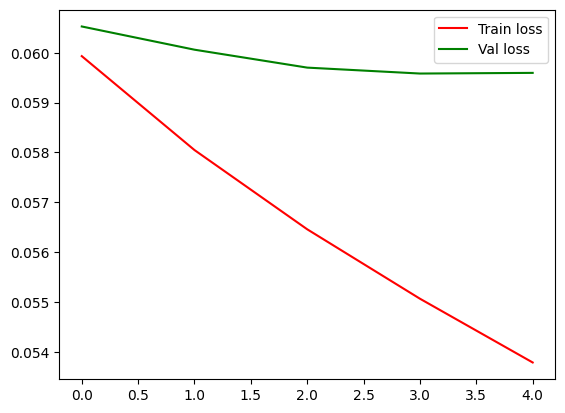

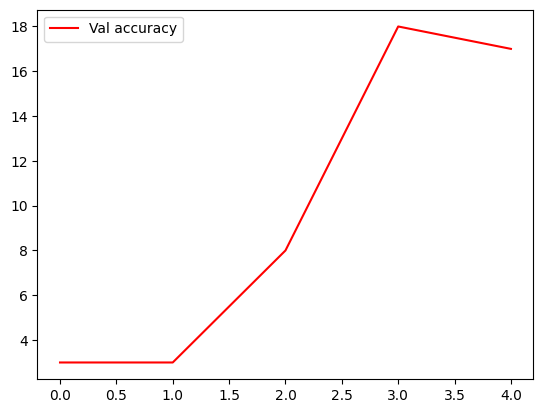

In [39]:
model.eval()

plt.figure(2)
plt.plot(train_losses, 'r', label='Train loss')
plt.plot(val_losses, 'g', label='Val loss')
plt.legend()
plt.show()

plt.figure(3)
plt.plot(val_accuracies, 'r', label='Val accuracy')
plt.legend()
plt.show()